<a href="https://colab.research.google.com/github/MarkusThill/MarkusThill.github.io-jupyter/blob/main/mahalanobis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\renewcommand{\vec}[1]{\boldsymbol{\mathbf{#1}}}$
$\def\matr#1{\boldsymbol{\mathbf{#1}}}$
$\def\tp{\mathsf T}$
$\newcommand{\E}{\mbox{I\negthinspace E}}$


# Mahalanobis Distance: Theory, Code, and Benchmarks

### Definition
The Mahalanobis distance between two points $\vec x, \vec y \in \mathbb R^n$ with covariance matrix $\matr \Sigma$ is  

$$
d(\vec x,\vec y) = \sqrt{(\vec x - \vec y)^\top \matr \Sigma^{-1} (\vec x - \vec y)}.
$$

In particular, the **squared Mahalanobis distance** between a vector $\vec x$ and the mean (centroid) $\vec \mu$ of a dataset is  

$$
D = d^2(\vec x, \vec \mu) = (\vec x - \vec \mu)^\top \matr \Sigma^{-1} (\vec x - \vec \mu).
$$

---

### Applications
- **Outlier detection:** measuring how far a point lies from the mean, relative to the covariance structure.  
- **Elliptical contours:** in 2D the boundary is an ellipse; in higher dimensions, an ellipsoid.  
- **Reconstruction error analysis:** e.g. in anomaly detection for high-dimensional data.

---

### Practical Considerations
- No Gaussian assumption is required, though Gaussian data gives special properties (see below).  
- If features are highly correlated, inverting $\matr \Sigma$ may cause numerical issues.  
- In very high dimensions ($>10^4$), computing $\matr \Sigma^{-1}$ is expensive — caching helps.  
- Most implementations compute the **squared** Mahalanobis distance $D$ for efficiency.  

---

### Quantiles and Chi-square Connection
- Unlike the univariate case, quantiles in the multivariate Gaussian are not simple tail integrals.  
- In 2D they correspond to ellipses; in higher dimensions, ellipsoids.  
- The squared Mahalanobis distance of Gaussian-distributed data is **Chi-square distributed** — allowing us to compute quantiles directly.  
- A naive Monte Carlo approach is possible but inefficient.  

---

### Further Reading
- [Wikipedia: Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance)  
- [Machine Learning Plus](https://www.machinelearningplus.com/statistics/mahalanobis-distance/)  
- [Statistics How To](https://www.statisticshowto.com/mahalanobis-distance/)  
- [Stats StackExchange Q&A](https://stats.stackexchange.com/questions/62092/bottom-to-top-explanation-of-the-mahalanobis-distance)  

---

👉 *In the next cells, we’ll implement the Mahalanobis distance step by step in Python, verify its properties, and visualize its relationship to the Chi-square distribution.*


In [1]:
# --- System setup ---
import os
os.environ["JAX_ENABLE_X64"] = "True"

# --- Core scientific stack ---
import numpy as np           # Standard CPU-based numerical computing
import scipy                 # Stats & scientific routines (e.g. chi-square, mahalanobis)

# --- GPU-accelerated backends ---
import jax.numpy as jnp       # NumPy-like API on top of JAX (for GPU/TPU acceleration)
import tensorflow as tf       # TensorFlow (also for GPU computing)
import tensorflow.keras.backend as K

# --- Visualization ---
import matplotlib.pyplot as plt


<a id="Implementations"></a>
## Offline Computation Approaches

In [2]:
def xnp_is_singular(X: np.ndarray | jnp.ndarray, eps: float = 1e-7, xnp=np) -> bool:
    """Check if a matrix is numerically singular using the log-determinant.

    Args:
        X: Input square matrix (NumPy or JAX array).
        eps: Small threshold for numerical stability.
        xnp: Backend to use (`np` or `jnp`).

    Returns:
        True if the matrix is close to singular, False otherwise.
    """
    sign, logdet = xnp.linalg.slogdet(X)  # Stable log(det(X))
    return logdet < xnp.log(eps)


def tf_is_singular(X: tf.Tensor, eps: float = 1e-7) -> bool:
    """Check if a symmetric positive-definite matrix is numerically singular (TensorFlow backend).

    Args:
        X: Input square matrix as a TensorFlow tensor.
        eps: Small threshold for numerical stability.

    Returns:
        True if the matrix is close to singular, False otherwise.
    """
    sign, logdet = tf.linalg.slogdet(X)
    return logdet.numpy() < np.log(eps)


def mahalanobis_distance_scipy(
    X: np.ndarray,
    cov: np.ndarray | None = None,
    mu: np.ndarray | None = None,
    inv_cov: np.ndarray | None = None,
    check_singular: bool = True,
) -> np.ndarray:
    """Compute the Mahalanobis distance for a dataset using SciPy.

    Args:
        X: Data matrix of shape (n_samples, n_features).
        cov: Covariance matrix (optional, will be estimated if None).
        mu: Mean vector (optional, will be estimated if None).
        inv_cov: Inverse covariance matrix (optional, computed if None).
        check_singular: Whether to check covariance matrix for singularity.

    Returns:
        Array of Mahalanobis distances for each sample.
    """
    if mu is None:
        mu = scipy.stats.tmean(X, axis=0)
    if cov is None:
        cov = np.cov(X, rowvar=False)
    if inv_cov is None:
        if check_singular and xnp_is_singular(cov, xnp=np):
            raise NotImplementedError("Cannot invert a singular covariance matrix!")
        inv_cov = scipy.linalg.inv(cov)

    return np.asarray([scipy.spatial.distance.mahalanobis(x, mu, inv_cov) for x in X])


def mahalanobis_distance_mlpcom(
    x: np.ndarray, data: np.ndarray, cov: np.ndarray | None = None
) -> np.ndarray:
    """Compute the Mahalanobis distance (reference implementation).

    From: https://www.machinelearningplus.com/statistics/mahalanobis-distance/

    Args:
        x: Vector or matrix of query points.
        data: Data matrix (used to compute mean and covariance if needed).
        cov: Covariance matrix of shape (n_features, n_features). If None, computed from `data`.

    Returns:
        Mahalanobis distance(s) for each sample in x.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    if cov is None:
        cov = np.cov(data.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    maha = np.dot(left_term, x_minus_mu.T)
    return maha.diagonal()


def xnp_mahalanobis_distance(
    X: np.ndarray | jnp.ndarray,
    cov: np.ndarray | jnp.ndarray | None = None,
    mu: np.ndarray | jnp.ndarray | None = None,
    inv_cov: np.ndarray | jnp.ndarray | None = None,
    xnp=jnp,
    check_singular: bool = True,
) -> np.ndarray | jnp.ndarray:
    """Compute the squared Mahalanobis distance for each row in X.

    Args:
        X: Data matrix of shape (n_samples, n_features).
        cov: Covariance matrix (optional, will be estimated if None).
        mu: Mean vector (optional, will be estimated if None).
        inv_cov: Inverse covariance matrix (optional, computed if None).
        xnp: Backend (`np` or `jnp`).
        check_singular: Whether to check covariance matrix for singularity.

    Returns:
        Array of squared Mahalanobis distances.
    """
    if mu is None:
        mu = xnp.mean(X, axis=0)
    if cov is None:
        cov = xnp.cov(X, rowvar=False)
    if inv_cov is None:
        if check_singular and xnp_is_singular(cov, xnp=xnp):
            raise NotImplementedError("Cannot invert a singular covariance matrix!")
        inv_cov = xnp.linalg.inv(cov)

    X_diff_mu = X - mu
    return xnp.apply_along_axis(lambda x: xnp.matmul(xnp.matmul(x, inv_cov), x.T), 1, X_diff_mu)


def xnp_mahalanobis_distance2(
    A: np.ndarray | jnp.ndarray,
    xnp=jnp,
    check_singular: bool = True,
) -> np.ndarray | jnp.ndarray:
    """Alternative implementation of squared Mahalanobis distance.

    Args:
        A: Data matrix of shape (n_samples, n_features).
        xnp: Backend (`np` or `jnp`).
        check_singular: Whether to check covariance matrix for singularity.

    Returns:
        Array of squared Mahalanobis distances.
    """
    mu = xnp.mean(A, axis=0, keepdims=False)
    M = A - mu
    cov = 1.0 / (A.shape[0] - 1) * xnp.dot(M.T, M)

    if check_singular and xnp_is_singular(cov, xnp=xnp):
        raise NotImplementedError("Cannot invert a singular covariance matrix!")

    X_mu_SInv = xnp.dot(M, xnp.linalg.inv(cov))
    return xnp.sum(X_mu_SInv * M, axis=1)


def tf_mat_inv(X: tf.Tensor) -> tf.Tensor:
    """Matrix inversion using TensorFlow Keras Lambda layer.

    Args:
        X: Input square matrix as a TensorFlow tensor.

    Returns:
        Inverse of the input matrix.
    """
    return tf.keras.layers.Lambda(lambda x: tf.linalg.inv(x))(X)


def tf_mahalanobis_distance(X: np.ndarray, check_singular: bool = True) -> np.ndarray:
    """Compute the squared Mahalanobis distance using TensorFlow backend.

    Args:
        X: Input data array of shape (n_samples, n_features).
        check_singular: Whether to check covariance matrix for singularity.

    Returns:
        Array of squared Mahalanobis distances.
    """
    A = K.variable(value=X)
    mu = K.mean(A, axis=0, keepdims=False)
    M = A - mu
    cov = 1.0 / (X.shape[0] - 1) * K.dot(K.transpose(M), M)

    if check_singular and tf_is_singular(cov):
        raise NotImplementedError("Cannot invert a singular covariance matrix!")

    A_mu_SInv = K.dot(M, tf_mat_inv(cov))
    A_mu_SInv_A_mu = tf.reduce_sum(A_mu_SInv * M, axis=1)

    return K.eval(A_mu_SInv_A_mu)


## Example 1: Mahalanobis Distances for 2-dimensional Dataset

In [3]:
# --- Example dataset ---
# Define a 2D covariance matrix with correlation
cov = np.array([[15, -3],
                [-3,  3.5]], dtype=np.float32)

# Draw 5000 samples from a 2D Gaussian distribution
# Using float32 for a fair comparison across NumPy, JAX, and TensorFlow
X = np.random.multivariate_normal(
    mean=[0.0, 0.0],
    cov=cov,
    size=5000
).astype("float32")

print(f"Shape of X: {X.shape}")
print(f"Sample mean (approx): {np.mean(X, axis=0)}")
print(f"Sample covariance (approx):\n{np.cov(X, rowvar=False)}")


Shape of X: (5000, 2)
Sample mean (approx): [ 0.04381604 -0.01415182]
Sample covariance (approx):
[[15.36180207 -2.96838132]
 [-2.96838132  3.44937792]]


In [4]:
def almost_equal(a: np.ndarray, b: np.ndarray, tol: float = 1e-5) -> bool:
    """Check if two arrays are approximately equal (mean absolute error < tol)."""
    return np.abs(a - b).mean() < tol


# --- Consistency checks across implementations ---
# Compare reference vs. JAX
assert almost_equal(
    mahalanobis_distance_mlpcom(x=X, data=X),
    xnp_mahalanobis_distance(X, xnp=jnp)
)

# Compare NumPy vs. JAX
assert almost_equal(
    xnp_mahalanobis_distance(X, xnp=np),
    xnp_mahalanobis_distance(X, xnp=jnp)
)

# Compare NumPy vs. TensorFlow
assert almost_equal(
    xnp_mahalanobis_distance(X, xnp=np),
    tf_mahalanobis_distance(X)
)

# Compare JAX vs. TensorFlow
assert almost_equal(
    xnp_mahalanobis_distance(X, xnp=jnp),
    tf_mahalanobis_distance(X)
)

# Compare alternative JAX/NumPy implementation vs. TensorFlow
assert almost_equal(
    xnp_mahalanobis_distance2(X, xnp=np),
    tf_mahalanobis_distance(X)
)
assert almost_equal(
    xnp_mahalanobis_distance2(X, xnp=jnp),
    tf_mahalanobis_distance(X)
)

# Compare SciPy (unsquared distances) vs. squared implementations
assert almost_equal(
    np.sqrt(xnp_mahalanobis_distance2(X, xnp=jnp)),
    mahalanobis_distance_scipy(X)
)

print("✅ All implementations produce consistent results within tolerance.")

✅ All implementations produce consistent results within tolerance.


In [5]:
# --- Timings for the individual variants (2-dim. distribution) ---
# Note: For small dimensions, GPU variants usually offer no advantage.

check_singular_cov = True  # For small covariance matrices this check is cheap

print("### Mahalanobis Distance Timing Benchmarks ###\n")

# reference implementation (machinelearningplus.com)
print(" Reference implementation:")
res_mlpcom = %timeit -o mahalanobis_distance_mlpcom(x=X, data=X)

# NumPy (variant 1)
print("\nNumPy variant 1:")
res_np1 = %timeit -o xnp_mahalanobis_distance(X, xnp=np, check_singular=check_singular_cov)

# JAX (variant 1, GPU/TPU if available)
print("\nJAX variant 1:")
res_jax1 = %timeit -o xnp_mahalanobis_distance(X, xnp=jnp, check_singular=check_singular_cov)

# NumPy (variant 2)
print("\nNumPy variant 2:")
res_np2 = %timeit -o xnp_mahalanobis_distance2(X, xnp=np, check_singular=check_singular_cov)

# JAX (variant 2)
print("\nJAX variant 2:")
res_jax2 = %timeit -o xnp_mahalanobis_distance2(X, xnp=jnp, check_singular=check_singular_cov)

# TensorFlow
print("\nTensorFlow variant:")
res_tf = %timeit -o tf_mahalanobis_distance(X, check_singular=check_singular_cov)

# SciPy builtin
print("\nSciPy (spatial.distance.mahalanobis):")
res_scipy = %timeit -o mahalanobis_distance_scipy(X)


### Mahalanobis Distance Timing Benchmarks ###

 Reference implementation:
133 ms ± 64.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

NumPy variant 1:
25.6 ms ± 727 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

JAX variant 1:
2.66 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

NumPy variant 2:
481 µs ± 62.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

JAX variant 2:
2.01 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

TensorFlow variant:
3.51 ms ± 60 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

SciPy (spatial.distance.mahalanobis):
27.8 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
print("\n--- Summary (mean execution time in ms) ---")
print(f"(machinelearningplus): {res_mlpcom.average * 1e3:.3f} ms")
print(f"NumPy variant 1:            {res_np1.average * 1e3:.3f} ms")
print(f"JAX variant 1:              {res_jax1.average * 1e3:.3f} ms")
print(f"NumPy variant 2:            {res_np2.average * 1e3:.3f} ms")
print(f"JAX variant 2:              {res_jax2.average * 1e3:.3f} ms")
print(f"TensorFlow:                 {res_tf.average * 1e3:.3f} ms")
print(f"SciPy (builtin):            {res_scipy.average * 1e3:.3f} ms")



--- Summary (mean execution time in ms) ---
(machinelearningplus): 133.035 ms
NumPy variant 1:            25.593 ms
JAX variant 1:              2.661 ms
NumPy variant 2:            0.481 ms
JAX variant 2:              2.014 ms
TensorFlow:                 3.512 ms
SciPy (builtin):            27.751 ms


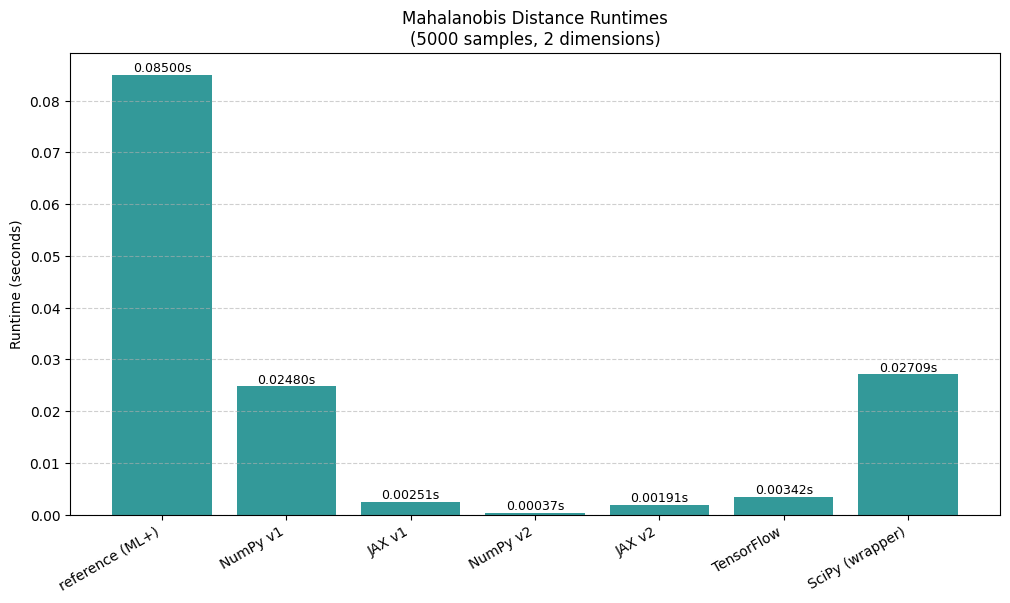

In [7]:
# --- Bar Chart of Benchmark Results (2D case) ---

# Collect runtimes (best of %timeit runs, in seconds)
results_dict_2d = {
    "reference (ML+)": res_mlpcom.best,
    "NumPy v1":             res_np1.best,
    "JAX v1":               res_jax1.best,
    "NumPy v2":             res_np2.best,
    "JAX v2":               res_jax2.best,
    "TensorFlow":           res_tf.best,
    "SciPy (wrapper)":      res_scipy.best,
}

# Keep original order (comment the next line if you want sorting by runtime)
# results_dict_2d = dict(sorted(results_dict_2d.items(), key=lambda x: x[1]))

# --- Plot ---
plt.figure(figsize=(12, 6))
bars = plt.bar(results_dict_2d.keys(), results_dict_2d.values(),
               color="teal", alpha=0.8)

plt.ylabel("Runtime (seconds)")
plt.title(f"Mahalanobis Distance Runtimes\n({X.shape[0]} samples, {X.shape[1]} dimensions)")

# Annotate bars
for bar, val in zip(bars, results_dict_2d.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{val:.5f}s", ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

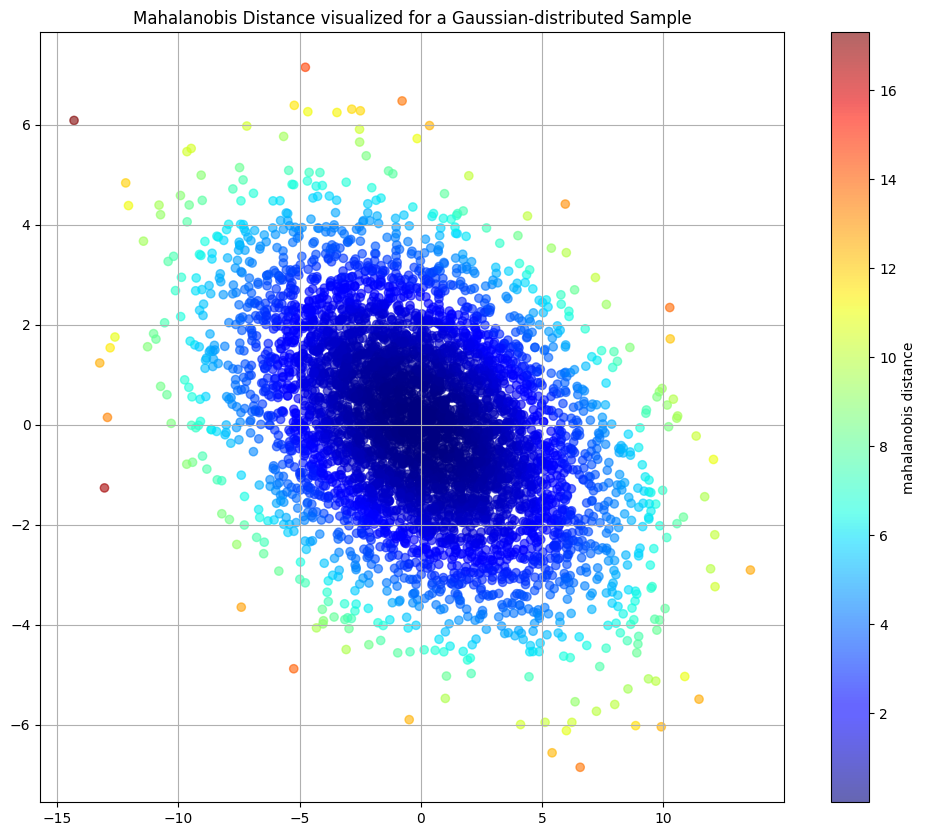

In [8]:
### Visualize the Mahalanobis distance
import matplotlib.pyplot as plt

X = np.random.multivariate_normal([0, 0], cov, size=5000)
plt.figure(figsize=(12,10))
plt.scatter(X[:,0], X[:,1], c=xnp_mahalanobis_distance(X, xnp=np, check_singular=True), alpha=0.6, cmap="jet")
plt.grid()
plt.colorbar(label="mahalanobis distance")
plt.title("Mahalanobis Distance visualized for a Gaussian-distributed Sample")
plt.show()

### Visualize the Whitening Property of the Mahalanobis Distance

The Mahalanobis distance can be understood geometrically through the **whitening transformation**:

- In the original space, Gaussian samples are distributed according to ellipses (in 2D) or ellipsoids (in higher dimensions).
- When computing the Mahalanobis distance, these ellipses are effectively transformed into **circles** (or spheres).  
- This transformation is called **whitening** (or, in this specific case, *Mahalanobis/ZCA whitening*), since it rescales and rotates the data so that the covariance matrix becomes the identity.

The plots below illustrate this property: first we see samples in their original correlated form (elliptical structure), and then their whitened version, where the distribution becomes isotropic.

---

**Further Reading**
- [Whitening transformation — Wikipedia](https://en.wikipedia.org/wiki/Whitening_transformation)


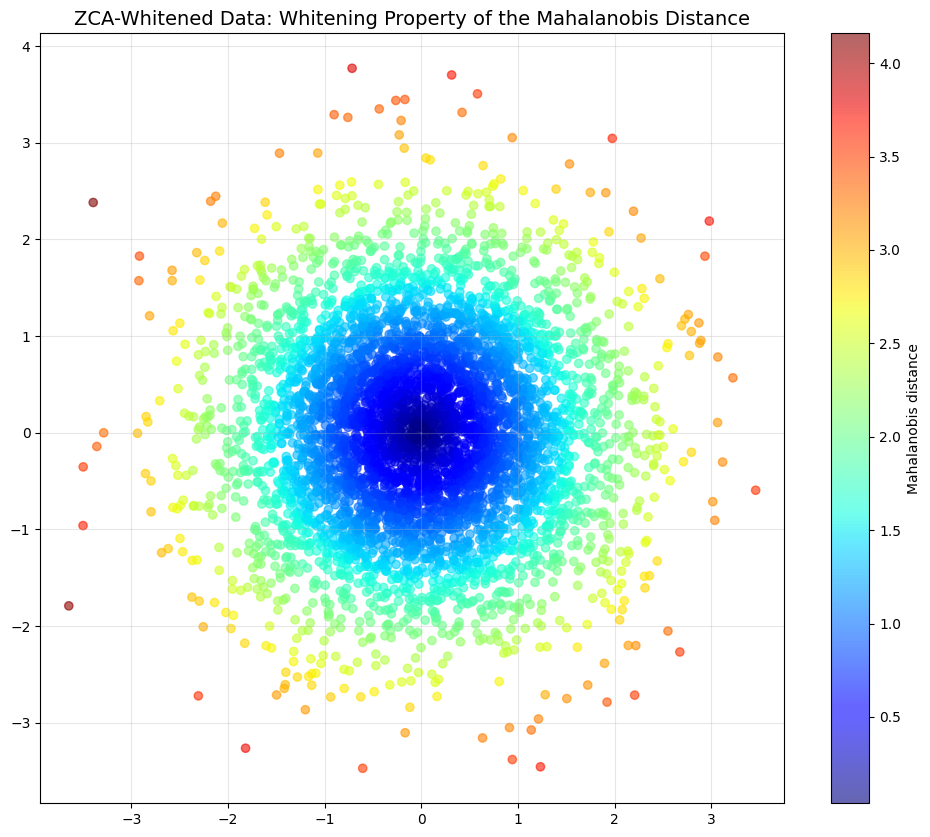

Mean absolute difference between Euclidean distance of whitened data and Mahalanobis distance: 0.013265


In [9]:
# --- Whitening Transformation Demo ---

# Compute the whitening (ZCA) matrix: Σ^{-1/2}
# This rescales and rotates the data such that the covariance becomes the identity
zca = scipy.linalg.sqrtm(np.linalg.inv(cov))

# Apply whitening transformation
X_white = np.dot(X, zca)

# Euclidean distances in whitened space
euclidean_dist = np.linalg.norm(X_white, axis=1, ord=2)

# Mahalanobis distances in original space
maha_dist = np.sqrt(
    xnp_mahalanobis_distance(X, xnp=np, check_singular=True)
)

# If we used the *true* mean and covariance instead of sample estimates,
# the difference between whitened Euclidean and Mahalanobis distances would be ~0.
# Try uncommenting this line to see the effect:
# maha_dist = np.sqrt(xnp_mahalanobis_distance(X, xnp=np, mu=[0,0], cov=cov, check_singular=True))

# --- Visualization ---
plt.figure(figsize=(12, 10))
sc = plt.scatter(
    X_white[:, 0], X_white[:, 1],
    c=maha_dist,
    alpha=0.6,
    cmap="jet"
)
plt.colorbar(sc, label="Mahalanobis distance")
plt.title("ZCA-Whitened Data: Whitening Property of the Mahalanobis Distance", fontsize=14)
plt.axis("equal")  # ensure circle-like appearance
plt.grid(alpha=0.3)
plt.show()

# --- Numerical check ---
mean_diff = np.abs(maha_dist - euclidean_dist).mean()
print(
    f"Mean absolute difference between Euclidean distance of whitened data "
    f"and Mahalanobis distance: {mean_diff:.6f}"
)


#### Visualize 3-dimensional Gaussian

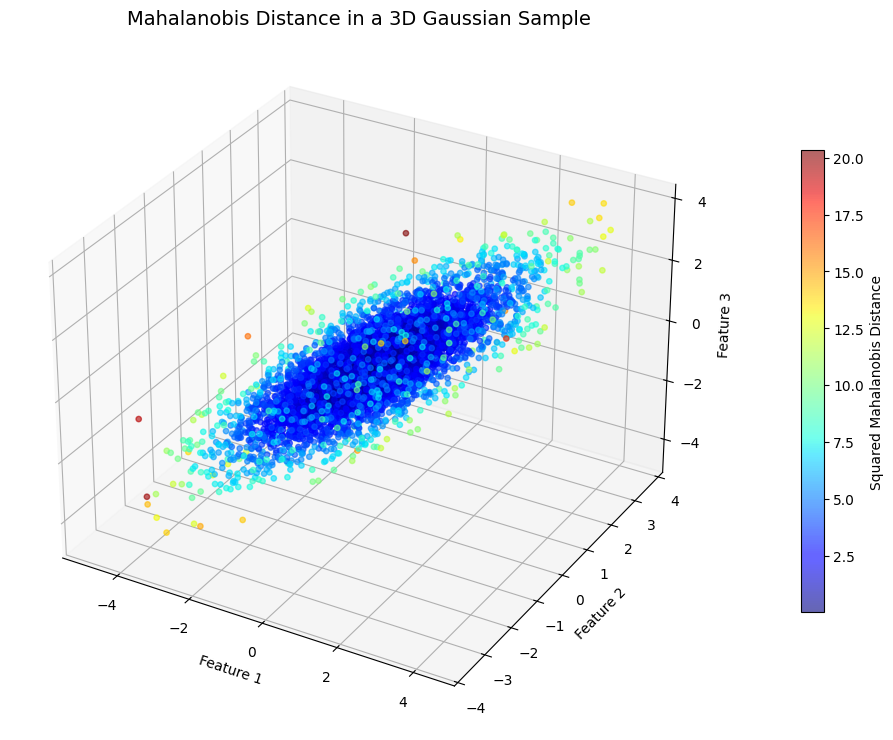

In [10]:
# --- 3D Mahalanobis Distance Visualization ---

# Generate a random positive definite covariance matrix
cov = np.random.rand(3, 3)
cov = np.dot(cov.T, cov) + np.eye(3) * 0.1  # add jitter to ensure positive definiteness

# Draw 5000 samples from the 3D Gaussian
X = np.random.multivariate_normal([0, 0, 0], cov, size=5000)

# Compute squared Mahalanobis distances
maha3 = xnp_mahalanobis_distance(X, xnp=np, check_singular=True)

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection="3d")

sc = ax.scatter(
    X[:, 0], X[:, 1], X[:, 2],
    c=maha3,
    alpha=0.6,
    cmap="jet",
    s=15
)

# Axis labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")

# Title
ax.set_title("Mahalanobis Distance in a 3D Gaussian Sample", fontsize=14)

# Colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Squared Mahalanobis Distance")

plt.show()


## Example 2: Mahalanobis Distances for high-dimensional Dataset

In [11]:
# --- High-dimensional dataset example ---
matrixSize = 2000   # dimensionality
n_samples = 10000   # number of samples

# Construct a random positive definite covariance matrix
A = np.random.rand(matrixSize, matrixSize).astype("float32")
cov = np.dot(A, A.T) + np.eye(matrixSize, dtype="float32") * 1e-3  # jitter for stability

# Random mean vector
mean = np.random.rand(matrixSize).astype("float32")

# Draw samples from multivariate Gaussian
X = np.random.multivariate_normal(mean, cov, size=n_samples).astype("float32")

print(f"Shape of dataset: {X.shape}")
print(f"Approximate memory usage of X: {X.nbytes/1e6:.1f} MB")

Shape of dataset: (10000, 2000)
Approximate memory usage of X: 80.0 MB


In [12]:
# --- Timings for the individual variants (high-dimensional distribution) ---
# Note: At high dimensions (e.g. 2000), inversion and distance computations
# become very expensive. GPU/TPU acceleration (JAX, TF) may provide speedups.

# You might want to disable check if you can ensure non-singularity
# since it is very costly for large covariance matrices
check_singular_cov = True

print("### Mahalanobis Distance Timing Benchmarks (High-Dimensional) ###\n")

# reference implementation (machinelearningplus.com)
print("reference implementation:")
res_mlpcom = %timeit -o mahalanobis_distance_mlpcom(x=X, data=X)

# NumPy (variant 1)
print("\nNumPy variant 1:")
res_np1 = %timeit -o xnp_mahalanobis_distance(X, xnp=np, check_singular=check_singular_cov)

# JAX (variant 1, GPU/TPU if available)
print("\nJAX variant 1:")
res_jax1 = %timeit -o xnp_mahalanobis_distance(X, xnp=jnp, check_singular=check_singular_cov)

# NumPy (variant 2)
print("\nNumPy variant 2:")
res_np2 = %timeit -o xnp_mahalanobis_distance2(X, xnp=np, check_singular=check_singular_cov)

# JAX (variant 2)
print("\nJAX variant 2:")
res_jax2 = %timeit -o xnp_mahalanobis_distance2(X, xnp=jnp, check_singular=check_singular_cov)

# TensorFlow
print("\nTensorFlow variant:")
res_tf = %timeit -o tf_mahalanobis_distance(X, check_singular=check_singular_cov)

# SciPy builtin
print("\nSciPy (spatial.distance.mahalanobis) wrapper:")
res_scipy = %timeit -o mahalanobis_distance_scipy(X)


### Mahalanobis Distance Timing Benchmarks (High-Dimensional) ###

reference implementation:
10.3 s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

NumPy variant 1:
19.2 s ± 690 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

JAX variant 1:
88.5 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

NumPy variant 2:
2.27 s ± 508 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

JAX variant 2:
74.5 ms ± 946 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

TensorFlow variant:
155 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

SciPy (spatial.distance.mahalanobis) wrapper:
17.8 s ± 719 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# --- Print collected timing results ---
print("\n### Timing Summary (High-Dimensional Mahalanobis Distance) ###\n")

def fmt(res):
    """Helper to format %timeit results in seconds"""
    return f"{res.best:.4f} s (best of {res.repeat} run(s))"

print(f"reference (machinelearningplus.com): {fmt(res_mlpcom)}")
print(f"NumPy variant 1:                         {fmt(res_np1)}")
print(f"JAX variant 1:                           {fmt(res_jax1)}")
print(f"NumPy variant 2:                         {fmt(res_np2)}")
print(f"JAX variant 2:                           {fmt(res_jax2)}")
print(f"TensorFlow:                              {fmt(res_tf)}")
print(f"SciPy (spatial.distance.mahalanobis):    {fmt(res_scipy)}")



### Timing Summary (High-Dimensional Mahalanobis Distance) ###

reference (machinelearningplus.com): 9.6409 s (best of 7 run(s))
NumPy variant 1:                         18.2225 s (best of 7 run(s))
JAX variant 1:                           0.0797 s (best of 7 run(s))
NumPy variant 2:                         1.8395 s (best of 7 run(s))
JAX variant 2:                           0.0734 s (best of 7 run(s))
TensorFlow:                              0.1505 s (best of 7 run(s))
SciPy (spatial.distance.mahalanobis):    17.0511 s (best of 7 run(s))


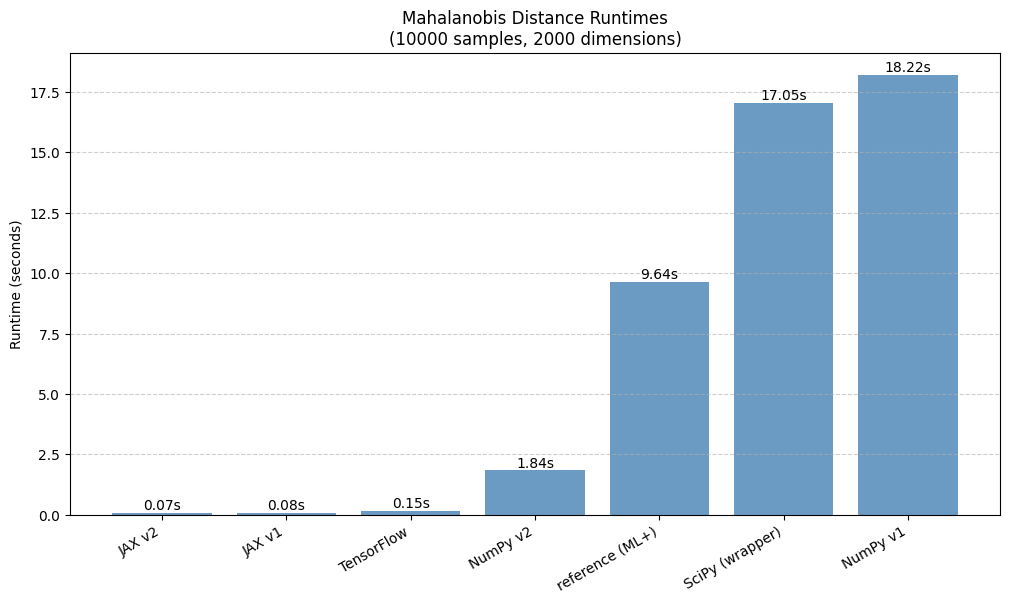

In [14]:
# --- Bar Chart of Benchmark Results ---

# Collect runtimes (best of %timeit runs, in seconds)
results_dict = {
    "reference (ML+)": res_mlpcom.best,
    "NumPy v1":             res_np1.best,
    "JAX v1":               res_jax1.best,
    "NumPy v2":             res_np2.best,
    "JAX v2":               res_jax2.best,
    "TensorFlow":           res_tf.best,
    "SciPy (wrapper)":      res_scipy.best,
}

# Sort methods by runtime (optional: comment out if you want original order)
results_dict = dict(sorted(results_dict.items(), key=lambda x: x[1]))

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(results_dict.keys(), results_dict.values(), color="steelblue", alpha=0.8)

plt.ylabel("Runtime (seconds)")
plt.title(f"Mahalanobis Distance Runtimes\n({X.shape[0]} samples, {X.shape[1]} dimensions)")

# Annotate bars with runtimes
for bar, val in zip(bars, results_dict.values()):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{val:.2f}s",
        ha="center", va="bottom", fontsize=10
    )

plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

## The (Squared) Mahalanobis Distance of a Gaussian Sample is $\chi^2$-Distributed!

- As shown in the derivations above, when the data is Gaussian, the **squared Mahalanobis distance** follows a $\chi^2$-distribution.  
- This result is extremely useful in practice: it means we can use **quantiles of the $\chi^2$-distribution** to set principled thresholds for anomaly detection.  
- For example, the **99th percentile** of $\chi^2$ gives a cutoff such that only 1% of points from the Gaussian distribution are expected to exceed it.  
- The number of **degrees of freedom** of the $\chi^2$-distribution equals the **dimensionality $n$** of the Gaussian distribution.  
- In other words:  
  $$
  D = (\vec x - \vec \mu)^\top \matr \Sigma^{-1} (\vec x - \vec \mu) \sim \chi^2_n
  $$
  if
  
  $$\vec x \sim \mathcal N(\vec \mu, \matr \Sigma)$$.


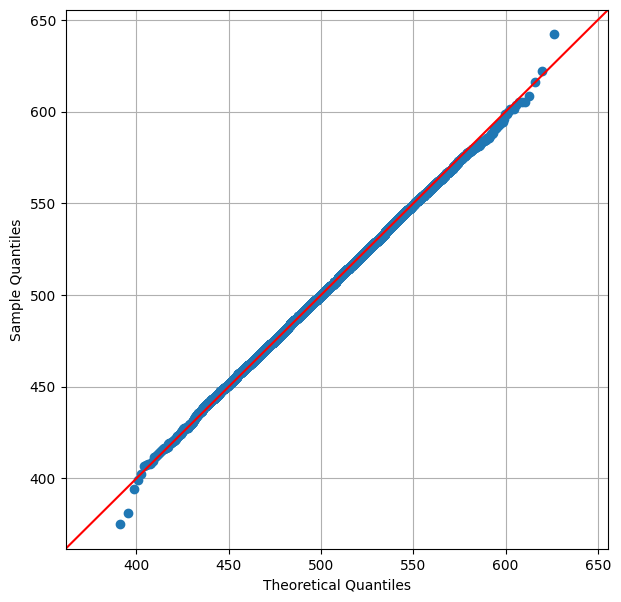

In [15]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import pylab as py

# Create sample
matrixSize = 500
A = np.random.rand(matrixSize, matrixSize)
cov = np.dot(A, A.transpose())  # Create a positive-semidefinite matrix
mean = np.random.rand(matrixSize)
X = np.random.multivariate_normal(mean, cov, size=10000)

# Compute squared maha distance
maha_dist = xnp_mahalanobis_distance2(X, xnp=jnp, check_singular=True)

# Quantile-Quantile plot: Ideally, the points are on the 45° line:
fig, ax = plt.subplots(1, figsize=(7, 7))
fig = sm.qqplot(maha_dist, stats.chi2, distargs=(matrixSize,), line="45", ax=ax)
ax.grid()
plt.show()

In [16]:
# Example for obtaining the 99th percentile
q = 0.99
print(
    f"Real (Empirical) {int(q*100)}-th Percentile of Mahalanobis distance for above sample: ", np.quantile(maha_dist, q)
)
print(f"{int(q*100)}-th percentile of chi2 distribution", scipy.stats.chi2.ppf(q, matrixSize))

Real (Empirical) 99-th Percentile of Mahalanobis distance for above sample:  574.5676507320717
99-th percentile of chi2 distribution 576.4928125116545


## Anomaly Detection Demo

Chi² threshold (99% quantile, df=2): 9.21
Detected 21 anomalies out of 530 samples


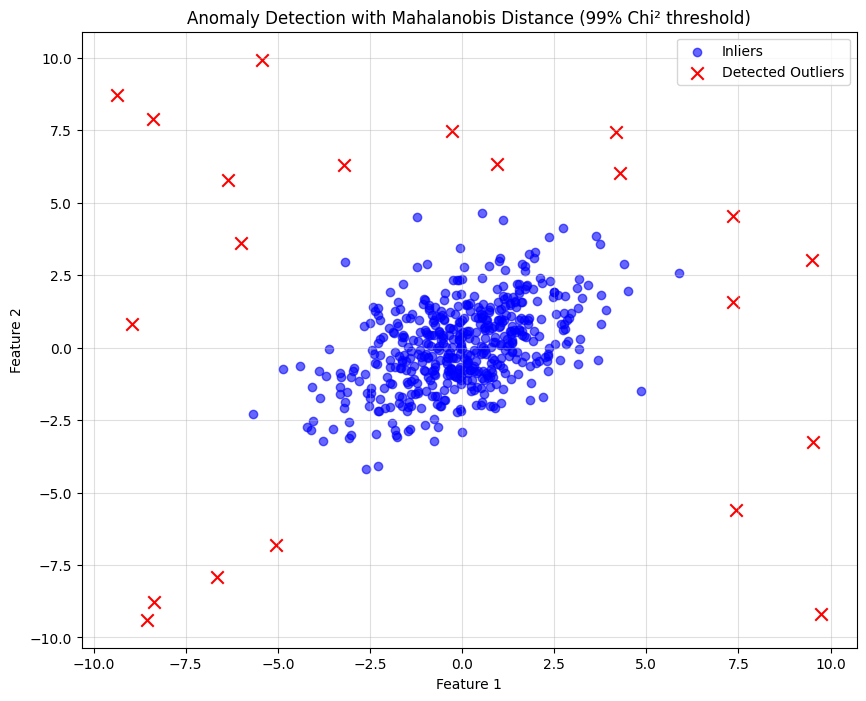

In [17]:
from scipy.stats import chi2

# --- Generate synthetic dataset ---
np.random.seed(42)

# Inliers: 2D Gaussian
mean = [0, 0]
cov = [[3, 1.2],
       [1.2, 2]]
X_inliers = np.random.multivariate_normal(mean, cov, size=500)

# Outliers: uniformly spread far away
X_outliers = np.random.uniform(low=-10, high=10, size=(30, 2))

# Combine dataset
X_full = np.vstack([X_inliers, X_outliers])

# --- Compute squared Mahalanobis distances ---
maha_dist_sq = xnp_mahalanobis_distance(X_full, xnp=np, check_singular=True)

# --- Chi-square threshold (99th percentile) ---
dim = X_full.shape[1]
threshold = chi2.ppf(0.99, df=dim)

# Identify anomalies
is_outlier = maha_dist_sq > threshold

print(f"Chi² threshold (99% quantile, df={dim}): {threshold:.2f}")
print(f"Detected {is_outlier.sum()} anomalies out of {X_full.shape[0]} samples")

# --- Visualization ---
plt.figure(figsize=(10, 8))
plt.scatter(X_full[~is_outlier, 0], X_full[~is_outlier, 1],
            c="blue", alpha=0.6, label="Inliers")
plt.scatter(X_full[is_outlier, 0], X_full[is_outlier, 1],
            c="red", marker="x", s=80, label="Detected Outliers")

plt.title("Anomaly Detection with Mahalanobis Distance (99% Chi² threshold)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(alpha=0.4)
plt.show()